In [1]:
import pandas as pd
import numpy as np
import glob
import scipy
import matplotlib.pyplot as plt
import re
import os
import librosa
import IPython.display as ipd
import librosa.display

In [2]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go unknown silence'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}

In [3]:
train_df = pd.read_pickle('train_df.pkl')

In [3]:
valid_df = pd.read_pickle('valid_df.pkl')

In [7]:
train_df["sound2"] = train_df.sound.apply(resize_wavs)

In [8]:
train_df.head(1)

,label,label_id,user_id,wav_file,sound,sound2
0,unknown,10,00176480,train/audio/bed/00176480_nohash_0.wav,"[3, 1, 6, 6, -1, 1, 8, 3, -3, -2, 3, 9, 4, -9,...","[3, 1, 6, 6, -1, 1, 8, 3, -3, -2, 3, 9, 4, -9,..."


In [9]:
sound2 = list(train_df.sound2)
label_id = list(train_df.label_id)

In [4]:
from scipy.io import wavfile

In [5]:
def wav2spec_val(X, max_len = 16000, n_mels = 128):
    """Turns audio into a spectrogram, used on validation data"""
    x_spec = np.zeros((len(X), n_mels, 32, 1))
    for i, fn in enumerate(X):
        _, wave = scipy.io.wavfile.read(fn)
        wave = wave[:max_len]
        wave = np.pad(wave, (0, max_len-wave.shape[0]), 'constant')
        # scales data from -1 to 1
        wave = wave / np.max([np.max(abs(wave)), 0.00001])
        S = librosa.feature.melspectrogram(wave, sr=16000, n_mels=n_mels)
        log_S = librosa.power_to_db(S, ref=np.max)
        x_spec[i,:,:,0] = log_S
    return x_spec

In [6]:
def wav2spec_train(X, max_len = 16000, n_mels = 128):
    """Turns audio into a spectrogram, used on training data"""
    x_spec = np.zeros((len(X), n_mels, 32, 1))
    for i, wave in enumerate(X):
        wave = wave[:max_len]
        wave = np.pad(wave, (0, max_len-wave.shape[0]), 'constant')
        # scales data from -1 to 1
        wave = wave / np.max([np.max(abs(wave)), 0.00001])
        S = librosa.feature.melspectrogram(wave, sr=16000, n_mels=n_mels)
        log_S = librosa.power_to_db(S, ref=np.max)
        x_spec[i,:,:,0] = log_S
    return x_spec

In [28]:
x_train_vec = wav2spec_train(sound2)
x_val_vec = wav2spec_val(valid_df.wav_file)

NameError: name 'sound2' is not defined

In [ ]:
x_train_vec.shape

In [ ]:
y_train_vec = np.array(label_id)
y_val_vec = valid_df.label_id.as_matrix()

In [ ]:
y_val_vec.shape

In [7]:
x_train_vec = np.load('x_train_vec.npy')
y_train_vec = np.load('y_train_vec.npy')

In [8]:
x_train_vec.shape

(57923, 128, 32, 1)

In [ ]:
x_val_vec = wav2spec_val(valid_df.wav_file)
y_val_vec = valid_df.label_id.as_matrix()

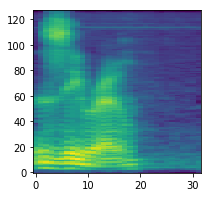

In [11]:
plt.figure(figsize=(3,3))
plt.imshow(x_train_vec[57922,:,:,0], aspect="auto", origin="lower")

In [ ]:
np.save('x_train_vec.npy', x_train_vec)

In [ ]:
np.save('y_train_vec.npy', y_train_vec)

In [ ]:
ind, counts = np.unique(y_train_vec, return_counts=True)

In [ ]:
class_weight = {i: count for i, count in zip(ind, counts)}

In [ ]:
class_weight = {ind: len(x_train_vec)/val for ind, val in class_weight.items()}

In [ ]:
import keras
import keras.backend as K

In [ ]:
num_labels = 11

In [32]:
x_train_vec[0].shape

(128, 32, 1)

In [ ]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(128,32,1)),
    keras.layers.Conv2D(64, kernel_size=(20,8), strides=1, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=(10,4), padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=(5,2), padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=(2,2), padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=(2,1), padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dropout(.5),
    keras.layers.Dense(250, activation="relu"),
    keras.layers.Dropout(.4),
    keras.layers.Dense(num_labels, activation="softmax")
])

model.compile(loss='sparse_categorical_crossentropy', 
               optimizer='nadam',
               metrics=['accuracy'])
print(model.summary())

In [6]:
from tensorflow.python.keras.callbacks import EarlyStopping

In [7]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1,
                           min_delta=0.01,
                           mode='min')]

In [21]:
history = model.fit(x_train_vec, y_train_vec,
                              batch_size = 512,
                              epochs=5,
                              verbose=1, 
                              callbacks=callbacks,
                              validation_data=(x_val_vec, y_val_vec),
                              class_weight = class_weight)

W1130 20:55:39.788097  5612 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 57923 samples, validate on 6798 samples
Epoch 1/5
57923/57923 [==============================] - 2408s 42ms/step - loss: 13.5118 - acc: 0.4263 - val_loss: 1.1725 - val_acc: 0.6677
Epoch 2/5
57923/57923 [==============================] - 2414s 42ms/step - loss: 5.6398 - acc: 0.7150 - val_loss: 0.6990 - val_acc: 0.7695
Epoch 3/5
57923/57923 [==============================] - 2413s 42ms/step - loss: 4.1055 - acc: 0.7947 - val_loss: 2.7617 - val_acc: 0.2117
Epoch 4/5
57923/57923 [==============================] - 2468s 43ms/step - loss: 4.2534 - acc: 0.8007 - val_loss: 0.4838 - val_acc: 0.8450
Epoch 5/5
57923/57923 [==============================] - 2655s 46ms/step - loss: 2.8150 - acc: 0.8627 - val_loss: 0.5152 - val_acc: 0.8304


In [22]:
for l in range(len(model.layers)):
    print(l, model.layers[l])

0 <keras.layers.convolutional.Conv2D object at 0x000002B4299C7A20>
1 <keras.layers.pooling.MaxPooling2D object at 0x000002B4299C7630>
2 <keras.layers.normalization.BatchNormalization object at 0x000002B4299C7748>
3 <keras.layers.convolutional.Conv2D object at 0x000002B4299C7C50>
4 <keras.layers.pooling.MaxPooling2D object at 0x000002B4299C7B70>
5 <keras.layers.normalization.BatchNormalization object at 0x000002B4299C7D30>
6 <keras.layers.convolutional.Conv2D object at 0x000002B4299C7FD0>
7 <keras.layers.pooling.MaxPooling2D object at 0x000002B4299D10F0>
8 <keras.layers.normalization.BatchNormalization object at 0x000002B4299D12E8>
9 <keras.layers.convolutional.Conv2D object at 0x000002B4299D1400>
10 <keras.layers.pooling.MaxPooling2D object at 0x000002B4299D1588>
11 <keras.layers.normalization.BatchNormalization object at 0x000002B4299D1630>
12 <keras.layers.convolutional.Conv2D object at 0x000002B4299D1748>
13 <keras.layers.pooling.MaxPooling2D object at 0x000002B4299D18D0>
14 <keras.

In [24]:
model.save('cnn_spectogram.h5')

In [16]:
from keras.models import load_model
model.load_weights('cnn_spectogram.h5')

In [17]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [18]:
def print_cmx (y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index = labels, columns = labels)
    
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmx, annot = True)
    plt.show()

In [19]:
y_testPred = model.predict(x_val_vec)
y_testP = []
for x in y_testPred:
    y_testP.append(x.argmax())
y_testP = np.array(y_testP)

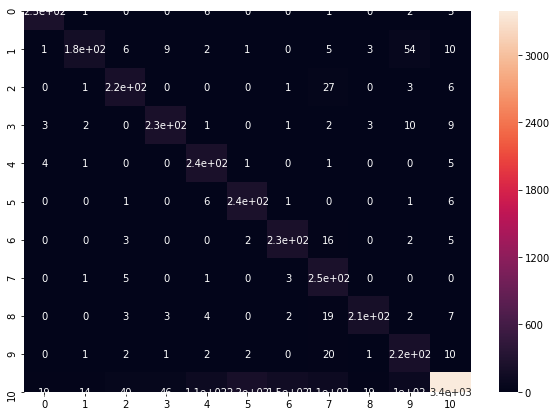

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       261
           1       0.90      0.66      0.76       270
           2       0.79      0.85      0.82       260
           3       0.80      0.88      0.84       264
           4       0.64      0.95      0.77       247
           5       0.52      0.94      0.67       256
           6       0.59      0.89      0.71       257
           7       0.55      0.96      0.70       256
           8       0.89      0.84      0.86       246
           9       0.55      0.85      0.67       260
          10       0.98      0.80      0.88      4221

    accuracy                           0.83      6798
   macro avg       0.74      0.87      0.78      6798
weighted avg       0.88      0.83      0.84      6798



In [20]:
from sklearn.metrics import classification_report

print_cmx(y_val_vec, y_testP)
print(classification_report(y_val_vec, y_testP))

In [21]:
getFeature = K.function([model.layers[0].input, K.learning_phase()],
                        [model.layers[19].output])

getPrediction = K.function([model.layers[20].input, K.learning_phase()],
                           [model.layers[20].output])

In [24]:
y_train3000 = y_train_vec[::23].reshape(y_train_vec[::23].shape[0],)
y_test1000 = y_val_vec[::4]

In [25]:
print(y_train3000.shape,y_test1000.shape)

(2519,) (1700,)


In [26]:
exTrain3000 = getFeature([x_train_vec[::23], 0])[0]

In [28]:
exTest1000 = getFeature([x_val_vec[::4], 0])[0]

In [29]:
print(exTrain3000.shape,exTest1000.shape)

(2519, 250) (1700, 250)


In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['rbf'], 
              'C':[1, 10, 100, 1000],
              'gamma':[1e-3, 1e-4]}
clf = GridSearchCV(SVC(), parameters)
clf.fit(exTrain3000, y_train3000)

C:\Users\cc\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [31]:
svmclf = clf.best_estimator_
svmclf.fit(exTrain3000, y_train3000)


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

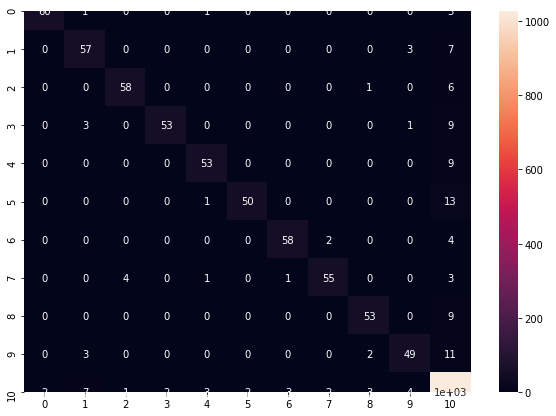

              precision    recall  f1-score   support

           0       0.97      0.92      0.94        65
           1       0.80      0.85      0.83        67
           2       0.92      0.89      0.91        65
           3       0.96      0.80      0.88        66
           4       0.90      0.85      0.88        62
           5       0.96      0.78      0.86        64
           6       0.94      0.91      0.92        64
           7       0.93      0.86      0.89        64
           8       0.90      0.85      0.88        62
           9       0.86      0.75      0.80        65
          10       0.93      0.97      0.95      1056

    accuracy                           0.93      1700
   macro avg       0.92      0.86      0.89      1700
weighted avg       0.93      0.93      0.92      1700



In [32]:
y_testSVM = svmclf.predict(exTest1000)

from sklearn.metrics import confusion_matrix, classification_report

print_cmx(y_test1000, y_testSVM)
print(classification_report(y_test1000, y_testSVM))

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parameters = {"n_neighbors": [10],
              "weights": ['distance'],
              "metric": ['euclidean','manhattan'],
              "algorithm": ['auto']}
kclf = KNeighborsClassifier()
kgclf = GridSearchCV(kclf, param_grid=parameters)
kgclf.fit(exTrain3000, y_train3000)

C:\Users\cc\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'algorithm': ['auto'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [10], 'weights': ['distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [46]:
kclf = kgclf.best_estimator_
kclf.fit(exTrain3000, y_train3000)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')

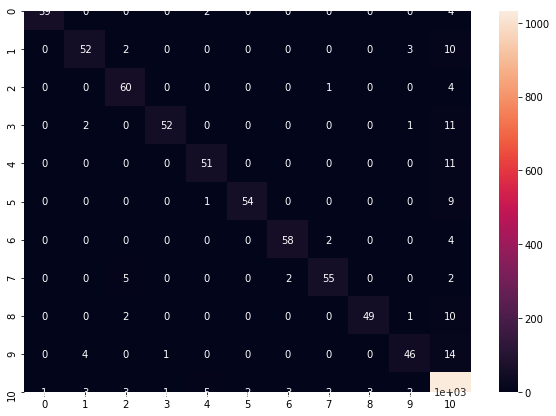

              precision    recall  f1-score   support

           0       0.98      0.91      0.94        65
           1       0.85      0.78      0.81        67
           2       0.83      0.92      0.88        65
           3       0.96      0.79      0.87        66
           4       0.86      0.82      0.84        62
           5       0.96      0.84      0.90        64
           6       0.92      0.91      0.91        64
           7       0.92      0.86      0.89        64
           8       0.94      0.79      0.86        62
           9       0.87      0.71      0.78        65
          10       0.93      0.98      0.95      1056

    accuracy                           0.92      1700
   macro avg       0.91      0.85      0.88      1700
weighted avg       0.92      0.92      0.92      1700



In [48]:
y_testKNN = kclf.predict(exTest1000)
from sklearn.metrics import confusion_matrix, classification_report

print_cmx(y_test1000, y_testKNN)
print(classification_report(y_test1000, y_testKNN))

In [44]:
print(y_testKNN)


[10 10 10 ... 10 10 10]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = {"max_depth": [3, None],
              "max_features": [10],
              "min_samples_split": [1.0, 3, 10],
              "min_samples_leaf": [10],
              "bootstrap": [True, False],
              "criterion": ["entropy"],
              "n_estimators": [50]}
rclf = RandomForestClassifier()
rgclf = GridSearchCV(rclf, param_grid=parameters)
rgclf.fit(exTrain3000, y_train3000)

In [ ]:
rclf = rgclf.best_estimator_
rclf.fit(exTrain3000, y_train3000)

In [ ]:
y_testRF = rclf.predict(exTest1000)

from sklearn.metrics import confusion_matrix, classification_report

print_cmx(y_test1000, y_testRF)
print(classification_report(y_test1000, y_testRF))